In [ ]:
import numpy as np
import cv2 as cv
import math
import matplotlib.pyplot as plt

In [22]:
def estimate_matrix(world_points, image_points):
    A = []
    for i in range(len(world_points)):
        X, Y, Z = tuple(world_points[i])
        u, v = tuple(image_points[i])
        eqn_1 = [X, Y, Z, 1] + [0] * 4 + [-u * X, -u * Y, -u * Z, -u]
        eqn_2 = [0] * 4 + [X, Y, Z, 1] + [-v * X, -v * Y, -v * Z, -v]
        A.append(eqn_1)
        A.append(eqn_2)
    U, S, V = np.linalg.svd(A)
    if V[-1, -1] == 0:
        return np.zeros((3, 4)), False
    return (V[-1, :] / V[-1, -1]).reshape(3, 4), True

In [23]:
def decompose_P(P):
    M = P[:, :3]
    R, K = np.linalg.qr(np.linalg.inv(M))
    K = np.linalg.inv(K)
    K /= K[-1, -1]
    R = np.linalg.inv(R)
    t = -1 * (np.linalg.inv(M) @ P[:, 3])
    return K, R, t

In [20]:
def get_total_error(world_points, image_points, P):
    n = len(image_points)
    total_error = 0
    for i in range(n):
        pred_point = P @ np.asarray(world_points[i] + [1])
        pred_point = pred_point / pred_point[-1]
        total_error += np.sum((pred_point[:2] - np.asarray(image_points[i])) ** 2)
    return total_error

 # Q1. 
Implement the DLT (Direct Linear Transformation) based calibration that we discussed in the class. You could use C/C++, Python or Matlab for this. However, you are expected to implement it yourselves and not use an existing implementation.

## Algorithm

DLT (Direct Linear Transform) involves considering a set of 3D real world points, and their corresponding 2D co-ordinates, and estimating a matrix P based on above correspondences, such that performing linear transformation on any 3D real world point would provide its 2D co-ordinate in the image.

In Homogeneous co-ordinates representation, a 3D point is represented as a column vector with 4 rows and a 2D point is represented by a column vector with 3 rows (the last constant is used for normalizing). Hence, P should be a 3 x 4 matrix, and thus 12 parameters are to be estimated. For every 3D - 2D point pair, 2 correspondences are obtained. Hence atleast 6 such points (i.e 12 correspondences) are necessary for estimating P. SVD is used on the correspondences matrix, and the eigenvector corresponding to the last column (least eigenvalue = 0) of V<sup>T</sup> is re-shaped and considered to be the P matrix.

Once P is estimated, the camera’s intrinsic parameter - Internal camera calibration matrix ‘K’, and extrinsic parameters - rotation matrix ‘R’ and vector of projection centre ‘t’ are calculated. Inverse of the first 3 columns of ‘P’, say ‘M’, is considered (for rotation to appear first and to retain appropriate order) and QR decomposition is applied to compute R and K, which are further inverted and normalized appropriately. The projection centre ‘t’ is computed as -M<sup>-1</sup>P<sub>4</sub> .

In [25]:
def direct_linear_transform(world_points, image_points):
    if len(world_points) != len(image_points) or len(world_points[0]) != 3 or len(image_points[0]) != 2:
        print("Invalid parameters for world and image co-ordinates")
        return
    if len(world_points) < 6:
        print("Atleast 6 points are necessary for calibration")
        return
    P, is_valid = estimate_matrix(world_points, image_points)
    if not is_valid:
        print("Invalid camera matrix")
        return
    K, R, t = decompose_P(P)
    return P, K, R, t

# Q2.
Implement the RANSAC based variant of the calibration that we discussed in the class. Note that these two algorithms use a set of known correspondences between real-world points and image points.

## Algorithm
RANSAC approach (Random Sample Consensus) functions similar to DLT in a way that it uses correspondences between 3D world coordinates and the corresponding 2D image co-ordinates. Though, it doesn’t consider all the 3D point - 2D point pairs for obtaining correspondences, and instead uses only a fixed number of them (atleast 6) for estimating the projection matrix ‘P’ (in the same way as discussed above in case of DLT - using SVD). 
The rest of the points are used to validate this estimated P matrix, and this is done by computing the distance between the predicted image co-ordinate and the actual corresponding value. If this distance is found to be higher than a pre-defined threshold, this particular pair is considered an ‘outlier’, and this check is performed for every pair, and thus for every choice of P, an ‘outlier’ count is obtained. 

Thus, these P matrix estimations and ‘outlier’ count computations are performed for a fixed (large) number of iterations, and the matrix which is found to produce the least number of outliers is deemed to be the projection matrix of the camera.

Once P is estimated, the camera’s intrinsic parameter - Internal camera calibration matrix ‘K’, and extrinsic parameters - rotation matrix ‘R’ and vector of projection centre ‘t’ are calculated in the same way as discussed above in the DLT approach.


In [26]:
def RANSAC(world_points, image_points, N_iter=10000, threshold=50, sample_size=6):
    if len(world_points) != len(image_points) or len(world_points[0]) != 3 or len(image_points[0]) != 2:
        print("Invalid parameters for world and image co-ordinates")
        return
    if len(world_points) < 6:
        print("Atleast 6 points are necessary for calibration")
        return
    P = np.zeros((3, 4))
    min_outlier_count = 10 ** 300
    for _ in range(N_iter):
        chosen_indices = np.random.choice(list(range(len(world_points))), size=sample_size, replace=False)
        chosen_world_points = [world_points[i] for i in chosen_indices]
        chosen_image_points = [image_points[i] for i in chosen_indices]
        possible_P, is_valid = estimate_matrix(chosen_world_points, chosen_image_points)
        if not is_valid:
            continue
        outlier_count = 0
        for i in range(len(world_points)):
            if i in chosen_indices:
                continue
            pred_point = possible_P @ np.asarray(world_points[i] + [1])
            if pred_point[-1] == 0:
                outlier_count += 1
                continue
            pred_point = pred_point / pred_point[-1]
            dist = np.sum((pred_point[:2] - np.asarray(image_points[i])) ** 2) ** 0.5
            if dist > threshold:
                outlier_count += 1
        if outlier_count < min_outlier_count:
            min_outlier_count = outlier_count
            P = possible_P
    K, R, t = decompose_P(P)
    return P, K, R, t

In [27]:
def get_image_points():
    line_1 = [[135, 278], [890, 330], [1655, 382], [2435, 435], [3242, 470], [4065, 515], [4920, 560]]
    line_2 = [[192, 1051], [928, 1113], [1675, 1165], [2440, 1225], [3225, 1280], [4036, 1333], [4872, 1390]]
    line_3 = [[661, 2110], [1430, 2170], [2225, 2240], [3033, 2320], [3870, 2385], [4730, 2465]]
    line_4 = [[331, 2410], [1153, 2470], [1990, 2562], [2845, 2643], [3730, 2725], [4643, 2800]]
    line_5 = [[828, 2825], [1722, 2925], [2625, 3002], [3567, 3088], [4547, 3175]]
    line_6 = [[470, 3225], [1411, 3322], [2382, 3413], [3390, 3505], [4432, 3615]]
    return line_1 + line_2 + line_3 + line_4 + line_5 + line_6

def get_world_points():
    line_1 = [[X, 72, 0] for X in reversed(range(0, 217, 36))]
    line_2 = [[X, 36, 0] for X in reversed(range(0, 217, 36))]
    line_3 = [[X, 0, 36] for X in reversed(range(0, 181, 36))]
    line_4 = [[X, 0, 72] for X in reversed(range(0, 181, 36))]
    line_5 = [[X, 0, 108] for X in reversed(range(0, 145, 36))]
    line_6 = [[X, 0, 144] for X in reversed(range(0, 145, 36))]
    return line_1 + line_2 + line_3 + line_4 + line_5 + line_6

image = cv.imread('../data/black-dots.JPG')
image_points = get_image_points()
world_points = get_world_points()

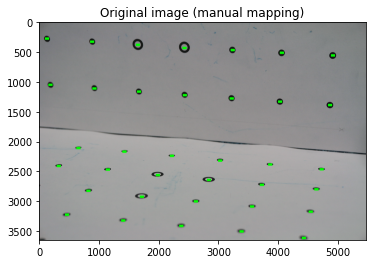

In [28]:
original_image = image.copy()
X_OFFSET = 35
Y_OFFSET = 20
for image_point in image_points:
    original_image[image_point[1] - Y_OFFSET:image_point[1] + Y_OFFSET,  
            image_point[0] - X_OFFSET:image_point[0] + X_OFFSET] = [0, 255, 0]
plt.imshow(original_image)
plt.title("Original image (manual mapping)")
plt.show()

In [29]:
def display_outputs(approach, image_points, P, K, R, t, color, given_image):
    global world_points, X_OFFSET, Y_OFFSET
    print(f"*** On using {approach} approach for camera calibration ***\n\n")
    print(f"Camera matrix (P): \n\n{P}\n")    
    print(f"Internal camera calibration matrix (K): \n\n{K}\n")
    print(f"Camera rotation matrix (R): \n\n{R}\n")    
    print(f"Camera projection centre (translation vector t): \n\n{t}\n")
    print(f"Total Projection error (sum): \n\n{get_total_error(world_points, image_points, P)}\n")
    if "distort" not in approach:
        for i in range(len(world_points)):
            pred_point = P @ np.asarray(world_points[i] + [1])
            pred_point = pred_point / pred_point[-1]
            pred_point = pred_point.astype(int)
            given_image[pred_point[1] - Y_OFFSET:pred_point[1] + Y_OFFSET,  
                    pred_point[0] - X_OFFSET:pred_point[0] + X_OFFSET] = color
        plt.imshow(given_image)

# Q3.
Use the image that is provided along with this assignment along with the real-world measurements that are given to you to compute the camera’s internal and external parameters using each of the above algorithms. Note that you need to manually estimate the image co-ordinates of the given world points. Describe your observations regarding the results.

<i>Note - Error is calculated as sum of squared distances between every actual image co-ordinated and its corresponding predicted value.</i>

*** On using DLT approach for camera calibration ***


Camera matrix (P): 

[[-2.10664177e+01 -1.57028792e+00 -9.65812749e+00  4.80395041e+03]
 [-1.12662758e+00 -2.25582390e+01  4.37384276e+00  2.16560900e+03]
 [ 3.37217247e-04 -6.45631796e-04 -1.59049947e-03  1.00000000e+00]]

Internal camera calibration matrix (K): 

[[-1.29271804e+04  1.25862968e+02  3.02953415e+03]
 [-0.00000000e+00 -1.29372810e+04  2.36183861e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Camera rotation matrix (R): 

[[-0.97755859  0.00800595 -0.21051155]
 [-0.0849721  -0.92936776  0.3592427 ]
 [-0.19276657  0.36906839  0.90919171]]

Camera projection centre (translation vector t): 

[-34.30846379 202.2883509  539.34428731]

Total Projection error (sum): 

2683.1272339152033



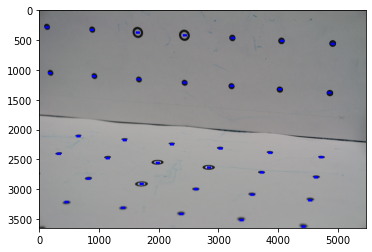

In [30]:
dlt_image = image.copy()
P, K, R, t = direct_linear_transform(world_points, image_points)
display_outputs("DLT", image_points, P, K, R, t, [0, 0, 255], dlt_image)

*** On using RANSAC approach for camera calibration ***


Camera matrix (P): 

[[-2.11380584e+01 -1.21368287e+00 -9.55381547e+00  4.80867671e+03]
 [-1.07590711e+00 -2.25068388e+01  4.60302444e+00  2.16218438e+03]
 [ 3.70499354e-04 -5.53111843e-04 -1.56454746e-03  1.00000000e+00]]

Internal camera calibration matrix (K): 

[[-1.33920946e+04  1.79823104e+02  2.69354300e+03]
 [-0.00000000e+00 -1.34214305e+04  1.67710382e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Camera rotation matrix (R): 

[[-9.73132446e-01 -5.69819119e-04 -2.30245345e-01]
 [-7.43751758e-02 -9.45609663e-01  3.16687068e-01]
 [-2.17902677e-01  3.25302999e-01  9.20161063e-01]]

Camera projection centre (translation vector t): 

[-35.90359381 211.47460712 555.89789049]

Total Projection error (sum): 

6117.241148891813



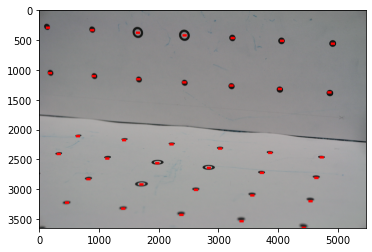

In [31]:
RANSAC_image = image.copy()
P, K, R, t = RANSAC(world_points, image_points)
display_outputs("RANSAC", image_points, P, K, R, t, [255, 0, 0], RANSAC_image)

## Observations

It can be understood that the values of the matrices / vectors obtained such as P, K, R, t are in fairly similar ranges. This is because the RANSAC approach was used for a large number of iterations (10,000) which provided relatively reliable results.

Although, it can also be observed that the results obtained by DLT have yielded less error value in comparison with RANSAC, which tells us about the inaccuracies which crept in when outliers were obtained in the RANSAC approach, due to setting of the threshold (50). 
Both the images (with highlighted points) seem fairly accurate, where DLT seems to slightly outperform RANSAC. 


# Q4.
Repeat the above experiments after correcting for radial distortion. Estimate the radial distortion parameters from the straight lines in the image. What do you observe regarding the resulting parameters?

## Concept
Distortion introduced to differential bending of light near the lens while capturing a lens, can be categorized into radial and tangential distortion.

Radial distortion is the reason why straight lines appear to be curved (can be observed clearly in checkerboards). Correcting for it requires estimation of parameters k1, k2, k3. It can be represented as shown below:

![Radial Distortion](./report_images/radial_dist_eqn.png "Radial Distortion")

Tangential distortion is observed when parallel alignment is not achieved between the lens capturing the lens and the image plane. It requires estimation of parameters p1 and p2. It can be represented as shown below:

![Tangential Distortion](./report_images/tangent_dist_eqn.png "Tangential Distortion")

These parameters are estimated using the calibrateCamera method of OpenCV package, and the image has further been undistorted by using the undistort method. This undistortion is carried out on application of above equations (after estimation of distortion co-efficients with the reference of straight lines in image data) to re-calculate the values for pixels of the image.

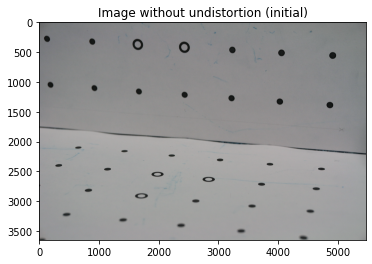



Distortion co-efficients are: 
Radial distortion: k1 = 0.5480195983374804, k2 = -5.9446792021901524, k3 = 24.285067446033757
Tangential distortion: p1 = -0.048860814141568905, p2 = -0.02835737850891691


New camera matrix: 
[[1.36310078e+04 0.00000000e+00 2.09220744e+03]
 [0.00000000e+00 1.33824365e+04 7.91644892e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]




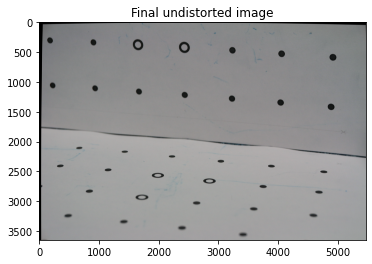

In [32]:
def get_distortion_params(K, image):
    global world_points, image_points
    plt.title("Image without undistortion (initial)")
    plt.imshow(image)
    plt.show()
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    wp = np.asarray([np.asarray(world_points[i]) for i in range(len(world_points))])
    ip = np.asarray([np.asarray(image_points[i]) for i in range(len(image_points))])
    obj_pts = [wp.astype('float32')]
    img_pts = [ip.astype('float32')]
    K = K @ [[-1,0,0],[0,-1,0],[0,0,1]] 
    K[0,1] = 0
    ret_val, new_K, distortion_coeffs, rvecs, tvecs = cv.calibrateCamera(obj_pts, img_pts, gray_image.shape[::-1], 
                                                                         K, None, None, flags = (cv.CALIB_USE_INTRINSIC_GUESS))
    print("\n\nDistortion co-efficients are: ")
    k1, k2, k3 = distortion_coeffs[0][0], distortion_coeffs[0][1], distortion_coeffs[0][4]
    p1, p2 = distortion_coeffs[0][2], distortion_coeffs[0][3]
    print(f"Radial distortion: k1 = {k1}, k2 = {k2}, k3 = {k3}")
    print(f"Tangential distortion: p1 = {p1}, p2 = {p2}\n\n")
    new_camera_matrix, roi = cv.getOptimalNewCameraMatrix(new_K, distortion_coeffs, image.shape[:2], 0, image.shape[:2])
    undistorted_image = cv.undistort(image, new_K, distortion_coeffs, new_camera_matrix)
    plt.imshow(undistorted_image)
    plt.title("Final undistorted image")
    print(f"New camera matrix: \n{new_camera_matrix}\n\n")
    return k1, k2, k3, p1, p2, rvecs, tvecs, new_camera_matrix, undistorted_image

k1, k2, k3, p1, p2, rvec, tvec, camera_matrix, undistorted_image = get_distortion_params(K, image.copy())
wp = [np.asarray(np.asarray([world_points[i]])) for i in range(len(world_points))]
new_image_points, jacobian = cv.projectPoints(np.asarray(wp).astype('float32'), rvec[0], tvec[0], camera_matrix, np.asarray([k1, k2, p1, p2, k3]))

In [33]:
# Repeating above experiments with radial distortion rectification
undistort_dlt_image = undistorted_image.copy()
P, K, R, t = direct_linear_transform(world_points, new_image_points.reshape(36, 2))
display_outputs("DLT (after correcting for radial distortion)", new_image_points.reshape(36, 2), P, K, R, t, [0, 0, 255], undistort_dlt_image)

*** On using DLT (after correcting for radial distortion) approach for camera calibration ***


Camera matrix (P): 

[[-2.15228940e+01 -1.46595898e+00 -9.70594512e+00  4.83468743e+03]
 [-1.12491734e+00 -2.23297921e+01  4.45826637e+00  2.11041126e+03]
 [ 3.40085555e-04 -5.99690630e-04 -1.57303438e-03  1.00000000e+00]]

Internal camera calibration matrix (K): 

[[-1.34440083e+04  1.10284885e+02  2.99257873e+03]
 [-0.00000000e+00 -1.31177569e+04  2.03252654e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Camera rotation matrix (R): 

[[-0.97687861  0.00654735 -0.21369443]
 [-0.08061233 -0.93703663  0.33979995]
 [-0.19801472  0.34916971  0.91589884]]

Camera projection centre (translation vector t): 

[-37.05194792 206.02078699 549.16182696]

Total Projection error (sum): 

1489.8754217039952



In [34]:
undistort_RANSAC_image = undistorted_image.copy()
P, K, R, t = RANSAC(world_points, new_image_points.reshape(36, 2))
display_outputs("RANSAC (after correcting for radial distortion)", new_image_points.reshape(36, 2), P, K, R, t, [255, 0, 0], undistort_RANSAC_image)

*** On using RANSAC (after correcting for radial distortion) approach for camera calibration ***


Camera matrix (P): 

[[-2.16520475e+01 -1.21264614e+00 -9.64049415e+00  4.84938443e+03]
 [-1.12227299e+00 -2.25113621e+01  4.59135291e+00  2.11082607e+03]
 [ 3.40064929e-04 -5.19790319e-04 -1.53097035e-03  1.00000000e+00]]

Internal camera calibration matrix (K): 

[[-1.40593436e+04  1.39841816e+02  2.94044810e+03]
 [-0.00000000e+00 -1.38333405e+04  1.57171958e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Camera rotation matrix (R): 

[[-0.97589962  0.00415268 -0.21818042]
 [-0.07248953 -0.9492123   0.30617198]
 [-0.2058281   0.31460891  0.92663694]]

Camera projection centre (translation vector t): 

[-42.44091948 212.46829865 571.61679567]

Total Projection error (sum): 

4358.5057845347255



## Observations
It can be seen that there has been an improvement in the calibration performances of DLT and RANSAC, on performing on an undistorted image. This can be said because error values for both cases have reduced significantly on considering the camera parameters after calibration with respect to distortion co-efficients.


# Q5. 
Use the real-world measurements that are provided along with the estimated camera parameters to compute the image of a wireframe of the object. Note that you will be computing the location of image points as xi = P.Xi , and not use the image points. Overlay (draw) the wireframe over the actual image of the object using straight lines between the computed points xi. What do you observe about the overlay?


WIREFRAMES


DLT: 




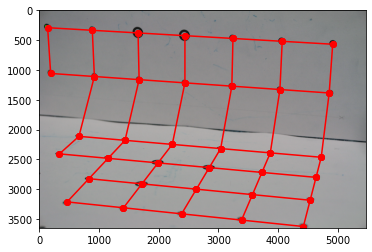


RANSAC: 




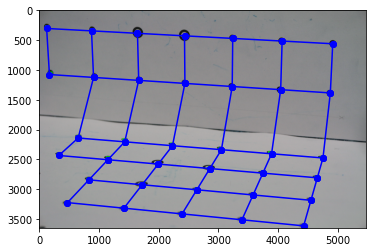

In [35]:
def draw_wireframe(P, image, color):
    plt.imshow(image)
    global world_points
    image_points = []
    for i in range(len(world_points)):
        pred_point = P @ np.asarray(world_points[i] + [1])
        pred_point = pred_point / pred_point[-1]
        image_points.append(pred_point)
    for i in range(7):
        plt.plot([image_points[i][0], image_points[i+7][0]], [image_points[i][1], image_points[i+7][1]], color)
    for i in range(8, 20):
        plt.plot([image_points[i][0], image_points[i+6][0]], [image_points[i][1], image_points[i+6][1]], color)
    for i in range(21, 31):
        plt.plot([image_points[i][0], image_points[i+5][0]], [image_points[i][1], image_points[i+5][1]], color)
    row_ranges = [(0, 7), (7, 14), (14, 20), (20, 26), (26, 31), (31, 36)]
    image_points = np.asarray(image_points)
    for _range in row_ranges:
        start, end = _range
        for i in range(start, end - 1):
            plt.plot(image_points[i:i+2, 0], image_points[i:i+2, 1], color)
    plt.show()

print("WIREFRAMES\n\n")
print("DLT: \n\n")
draw_wireframe(direct_linear_transform(world_points, image_points)[0], original_image.copy(), 'ro-')
print("\nRANSAC: \n\n")
draw_wireframe(RANSAC(world_points, image_points)[0], original_image.copy(), 'bo-')

## Observations
The overlay clearly highlights the straight lines which are associated with the image captured, and confirms the uniformity of spread of the points. Although due to perspective view, the points which are present relatively closer to the viewer appear to have smaller distances between 2 points. It can also be noted that wireframes obtained in both cases are fairly similar.


# Q6. 
Repeat the calibration of the camera using Zhang’s method using either the available OpenCV or Matlab implementation. How does your result compare with the DLT based method?

## Code
OpenCV’s inbuilt method was used for implementation of Zhang’s method. Images of the checkerboard provided (in the data folder) were utilized.

In [23]:
def eulerAnglesToRotationMatrix(theta) :
    R_x = np.array([[1,0,0],[0,math.cos(theta[0]),-math.sin(theta[0])],[0,math.sin(theta[0]), math.cos(theta[0])]])
    R_y = np.array([[math.cos(theta[1]),0,math.sin(theta[1])],[0,1,0],[-math.sin(theta[1]),0,math.cos(theta[1])]])             
    R_z = np.array([[math.cos(theta[2]),-math.sin(theta[2]),0],[math.sin(theta[2]),math.cos(theta[2]),0],[0,0,1]])
    R = np.dot(R_z,np.dot(R_y,R_x))
    return R

def zhang():
    image_names = [f"checkerboard-0{i}.JPG" for i in range(1, 10)] + [f"checkerboard-{i}.JPG" for i in range(10, 16)]
    edge_length, inner_row_count, inner_col_count, board_world_coords = 29, 6, 8, []
    for y in range(0, edge_length * inner_row_count, edge_length):
        for x in range(0, edge_length * inner_col_count, edge_length):
            board_world_coords.append(np.asarray([x, y, 0]))
    board_world_coords = np.asarray(board_world_coords)
    
    world_coords, image_coords = [], []
    for _n in image_names:
        board_image = cv.imread('../data/' + _n)
        gray_image = cv.cvtColor(board_image, cv.COLOR_BGR2GRAY)
        ret_val, corners = cv.findChessboardCorners(gray_image, (inner_col_count, inner_row_count))
        world_coords.append(board_world_coords)
        image_coords.append(corners)
    world_coords = np.asarray(world_coords).astype(np.float32)
    image_coords = np.asarray(image_coords).astype(np.float32)
    
    ret_val, K, distortion_coeffs, rvecs, tvecs = cv.calibrateCamera(world_coords, image_coords, gray_image.shape[::-1], None, None)
    print(f"Internal camera calibration matrix (K): \n\n{K}\n")
    print("\nDistortion co-efficients are: ")
    k1, k2, k3 = distortion_coeffs[0][0], distortion_coeffs[0][1], distortion_coeffs[0][4]
    p1, p2 = distortion_coeffs[0][2], distortion_coeffs[0][3]
    print(f"Radial distortion: k1 = {k1}, k2 = {k2}, k3 = {k3}")
    print(f"Tangential distortion: p1 = {p1}, p2 = {p2}\n\n")
    print(f"\nRotation vectors: \n\n{rvecs}\n")
    print(f"\nTranslation vectors: \n\n{tvecs}\n")
    
    R = eulerAnglesToRotationMatrix(rvecs[0])
    t = tvecs[0][:, 0]
    P = K @ np.column_stack((R, t))
    print(f"\nTotal Projection error (sum): \n\n{get_total_error(board_world_coords.tolist(), image_coords[0].reshape(48, 2), P)}\n")
    return k1, k2, k3, p1, p2, P, K, board_world_coords

k1_b, k2_b, k3_b, p1_b, p2_b, P_board, K_board, board_world_coords = zhang()

Internal camera calibration matrix (K): 

[[1.36634773e+04 0.00000000e+00 3.33653656e+03]
 [0.00000000e+00 1.36813826e+04 1.49660118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


Distortion co-efficients are: 
Radial distortion: k1 = 0.09521322924130345, k2 = 10.109258031779158, k3 = -160.58962196859986
Tangential distortion: p1 = -0.015279779906358974, p2 = 0.028721343436312705



Rotation vectors: 

(array([[-0.01318085],
       [-0.05189257],
       [-0.00310183]]), array([[-0.00723369],
       [ 0.22652165],
       [ 0.03532859]]), array([[-0.00906861],
       [-0.41619662],
       [-0.03572076]]), array([[ 0.01633962],
       [-0.61839259],
       [-0.07755518]]), array([[0.00456626],
       [0.30778498],
       [0.06543949]]), array([[-0.32566614],
       [-0.22232074],
       [-0.01742858]]), array([[-0.19221712],
       [-0.38502427],
       [-0.00381479]]), array([[ 0.24427921],
       [-0.32262063],
       [ 0.02472159]]), array([[0.31114498],
       [0.0663294 ],
 

## Observations
It can be seen that the camera calibration matrix ‘K’ and the distortion parameters obtained on using Zhang’s method are fairly similar to the parameters obtained on using DLT. 

Although DLT seemed to slightly outperform Zhang’s method, in this case (probably due to slight disparities in correspondences depicted by multiple checkerboards, in comparison with the image used in case of DLT). 

The undistorted images also seem to pan out similar to the case of DLT.


# Q7. 
Repeat the overlay of the wireframe using the internal parameters estimated from Zhang’s method. Describe your observations.

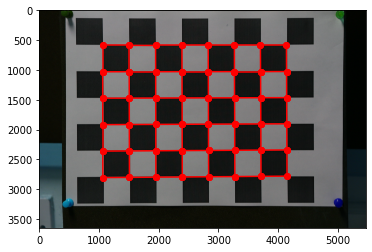

WIREFRAME OF BOARD (ZHANG'S METHOD) 


New camera matrix: 
[[1.37530576e+04 0.00000000e+00 3.35841150e+03]
 [0.00000000e+00 1.37132959e+04 1.48632820e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]




In [37]:
def zhang_wireframe_and_undistort(k1, k2, k3, p1, p2, P, K, board_world_coords, image, color):
    img_points = []
    plt.imshow(image)
    for i in range(len(board_world_coords)):
        pred_point = P @ np.asarray(board_world_coords[i].tolist() + [1])
        pred_point = pred_point / pred_point[-1]
        pred_point = pred_point.astype(int)
        img_points.append(pred_point)
    img_points = np.asarray(img_points)
    for i in range(len(board_world_coords) - 1):
        if i % 8 == 7:
            continue
        plt.plot([img_points[i][0], img_points[i+1][0]], [img_points[i][1], img_points[i+1][1]], color)
    for i in range(8):
        for j in range(i, 40, 8):
            plt.plot([img_points[j][0], img_points[j+8][0]], [img_points[j][1], img_points[j+8][1]], color)
    plt.show()
    print("WIREFRAME OF BOARD (ZHANG'S METHOD) \n\n")
    new_camera_matrix, roi = cv.getOptimalNewCameraMatrix(K, np.asarray([[k1, k2, p1, p2, k3]]), image.shape[:2], 0, image.shape[:2])
    undistorted_image = cv.undistort(image, K, np.asarray([[k1, k2, p1, p2, k3]]), new_camera_matrix)
    print(f"New camera matrix: \n{new_camera_matrix}\n\n")
    return undistorted_image
    
img = cv.imread('../data/checkerboard-01.JPG')  
undistorted_image = zhang_wireframe_and_undistort(k1_b, k2_b, k3_b, p1_b, p2_b, 
                                                  P_board, K_board, board_world_coords, img, 'ro-')

## Observations
Similar to the case of DLT, the straight lines seem to be more apparent on drawing the overlay. Although, very minor distortions seem to be present, as few lines (especially on the outer side) appear slightly curved.

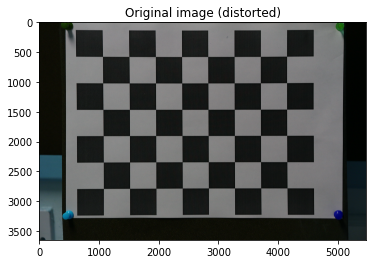

In [38]:
plt.imshow(img)
plt.title("Original image (distorted)")
plt.show()

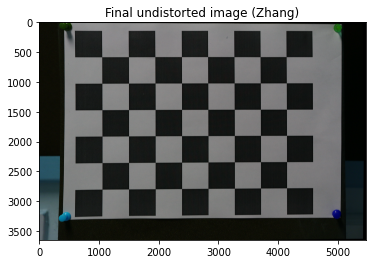

In [39]:
plt.imshow(undistorted_image)
plt.title("Final undistorted image (Zhang)")
plt.show()

# Q8. 
What is the image of the world origin, given the calibration matrix? Does this result bear out in your observations?

## Ans
For the given calibration matrix, the image of the world origin is the centre of projection of the image. It can be obtained by transforming the origin to its corresponding image co-ordinate, by multiplying with the calibration matrix P. This can be viewed clearly in the image below, where the origin is highlighted in red.

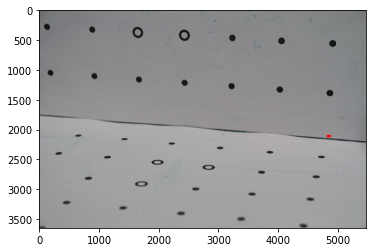

In [40]:
def plot_origin(P, color, given_image):
    world_origin = P @ np.asarray([0, 0, 0, 1])
    world_origin /= world_origin[-1]
    world_origin = np.asarray(world_origin).astype(int)
    given_image[world_origin[1] - Y_OFFSET:world_origin[1] + Y_OFFSET,  
                world_origin[0] - X_OFFSET:world_origin[0] + X_OFFSET] = color
    plt.imshow(given_image)
    plt.show()

plot_origin(P, [255, 0, 0], image.copy())